In [17]:
from torch.utils.data import DataLoader, Dataset
from typing import List
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import gc
from einops import einsum

In [18]:
from pipeline.load_activations import load_activations

In [19]:
activations_dir="/workspace/llm-progress-monitor/rollouts-big/test/activations"

In [20]:
activations = load_activations(activations_dir)

2025-10-07 14:54:15,216 - INFO - Loading activations from: /workspace/llm-progress-monitor/rollouts-big/test/activations
2025-10-07 14:54:15,218 - INFO - Loading activations from index 0 to 100
2025-10-07 14:54:15,218 - INFO - Loading activations from index 0 to 100
2025-10-07 14:54:16,362 - INFO - Loaded 100 activations
2025-10-07 14:54:16,528 - INFO - Successfully loaded 100 activations
2025-10-07 14:54:16,362 - INFO - Loaded 100 activations
2025-10-07 14:54:16,528 - INFO - Successfully loaded 100 activations


In [21]:
activations[0].activations.shape

torch.Size([1, 445, 2560])

In [22]:
balanced_lin_to_lin_betas = torch.load("/root/llm-progress-monitor/final_write_up/balanced_lin_to_lin_betas.pt").to('cpu').to(torch.float32)
balanced_lin_to_log_betas = torch.load("/root/llm-progress-monitor/final_write_up/balanced_lin_to_log_betas.pt").to('cpu').to(torch.float32)
balanced_log_bin_classifier = torch.load("/root/llm-progress-monitor/final_write_up/balanced_log_bin_classifier.pt")

In [23]:
# Extract the weight tensor from the OrderedDict
log_bin_weight = balanced_log_bin_classifier['linear.weight'].to(torch.float32).to('cpu')
print(f"Log bin classifier weight shape: {log_bin_weight.shape}")
print(f"This represents {log_bin_weight.shape[0]} classifier vectors, each of dimension {log_bin_weight.shape[1]}")

Log bin classifier weight shape: torch.Size([10, 2560])
This represents 10 classifier vectors, each of dimension 2560


In [24]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Function to calculate cosine similarity
def cosine_similarity(v1, v2):
    return torch.nn.functional.cosine_similarity(v1.flatten(), v2.flatten(), dim=0)

In [26]:
# Cosine similarity between lin_to_lin and lin_to_log
cos_sim_lin_to_lin_vs_lin_to_log = cosine_similarity(balanced_lin_to_lin_betas, balanced_lin_to_log_betas)
print(f"Cosine similarity between lin_to_lin and lin_to_log: {cos_sim_lin_to_lin_vs_lin_to_log:.4f}")

Cosine similarity between lin_to_lin and lin_to_log: 0.7309


In [27]:
# Calculate cosine similarities between lin_to_lin and all vectors in log_bin_classifier
cos_sims_lin_to_lin_vs_log_bin = []
for i in range(log_bin_weight.shape[0]):
    cos_sim = cosine_similarity(balanced_lin_to_lin_betas, log_bin_weight[i])
    cos_sims_lin_to_lin_vs_log_bin.append(cos_sim.item())

# Calculate cosine similarities between lin_to_log and all vectors in log_bin_classifier
cos_sims_lin_to_log_vs_log_bin = []
for i in range(log_bin_weight.shape[0]):
    cos_sim = cosine_similarity(balanced_lin_to_log_betas, log_bin_weight[i])
    cos_sims_lin_to_log_vs_log_bin.append(cos_sim.item())

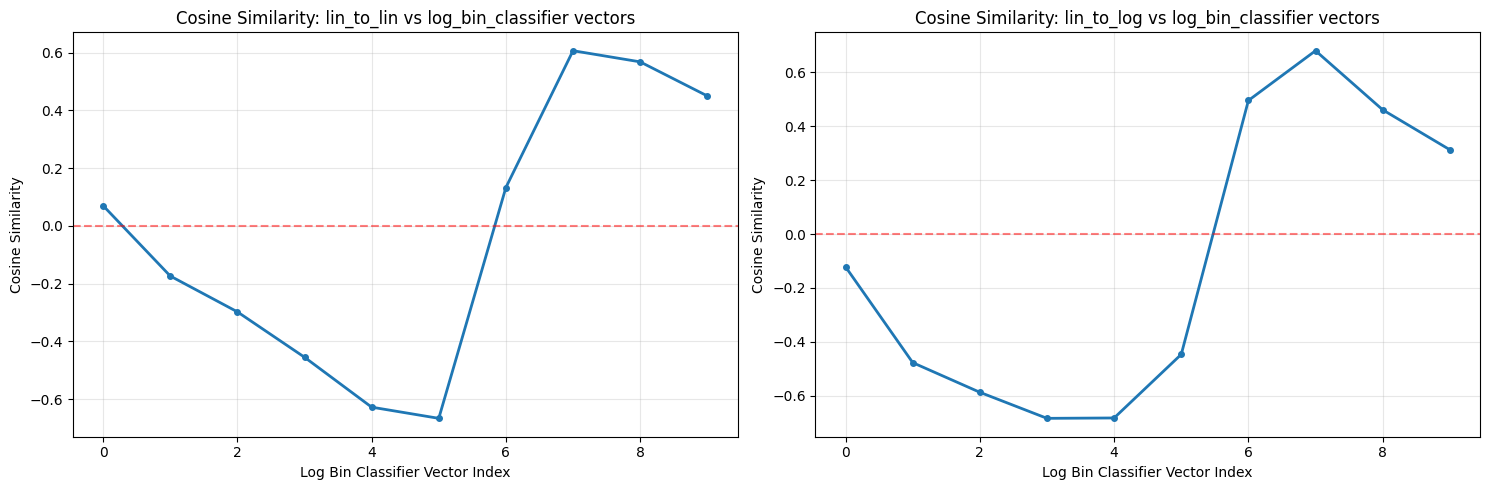


Number of log_bin_classifier vectors: 10
Mean cosine similarity (lin_to_lin vs log_bin): -0.0393
Mean cosine similarity (lin_to_log vs log_bin): -0.1049


In [28]:
# Create the two graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graph 1: lin_to_lin vs log_bin_classifier vectors
ax1.plot(cos_sims_lin_to_lin_vs_log_bin, marker='o', linestyle='-', linewidth=2, markersize=4)
ax1.set_xlabel('Log Bin Classifier Vector Index')
ax1.set_ylabel('Cosine Similarity')
ax1.set_title('Cosine Similarity: lin_to_lin vs log_bin_classifier vectors')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Graph 2: lin_to_log vs log_bin_classifier vectors
ax2.plot(cos_sims_lin_to_log_vs_log_bin, marker='o', linestyle='-', linewidth=2, markersize=4)
ax2.set_xlabel('Log Bin Classifier Vector Index')
ax2.set_ylabel('Cosine Similarity')
ax2.set_title('Cosine Similarity: lin_to_log vs log_bin_classifier vectors')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"\nNumber of log_bin_classifier vectors: {log_bin_weight.shape[0]}")
print(f"Mean cosine similarity (lin_to_lin vs log_bin): {np.mean(cos_sims_lin_to_lin_vs_log_bin):.4f}")
print(f"Mean cosine similarity (lin_to_log vs log_bin): {np.mean(cos_sims_lin_to_log_vs_log_bin):.4f}")

# Option 1: Scalar Trajectory - Project residual streams onto probe direction

In [29]:
def compute_scalar_trajectory(residual_stream, probe_direction):
    """
    Compute scalar projection of residual stream onto normalized probe direction.
    
    Args:
        residual_stream: tensor of shape [seq_len, d_model] (bfloat16)
        probe_direction: tensor of shape [d_model] (float32)
    
    Returns:
        progress_scores: tensor of shape [seq_len] showing alignment with probe
    """
    # Convert bfloat16 to float32 for computation
    residual_stream_f32 = residual_stream.float()
    
    # Normalize the probe direction
    probe_normalized = probe_direction / torch.norm(probe_direction)
    
    # Project each token's residual onto the normalized probe
    # progress_scores[t] = residual_stream[t] · probe_direction / ||probe_direction||
    progress_scores = einsum(residual_stream_f32, probe_normalized, "seq d, d -> seq")
    
    return progress_scores

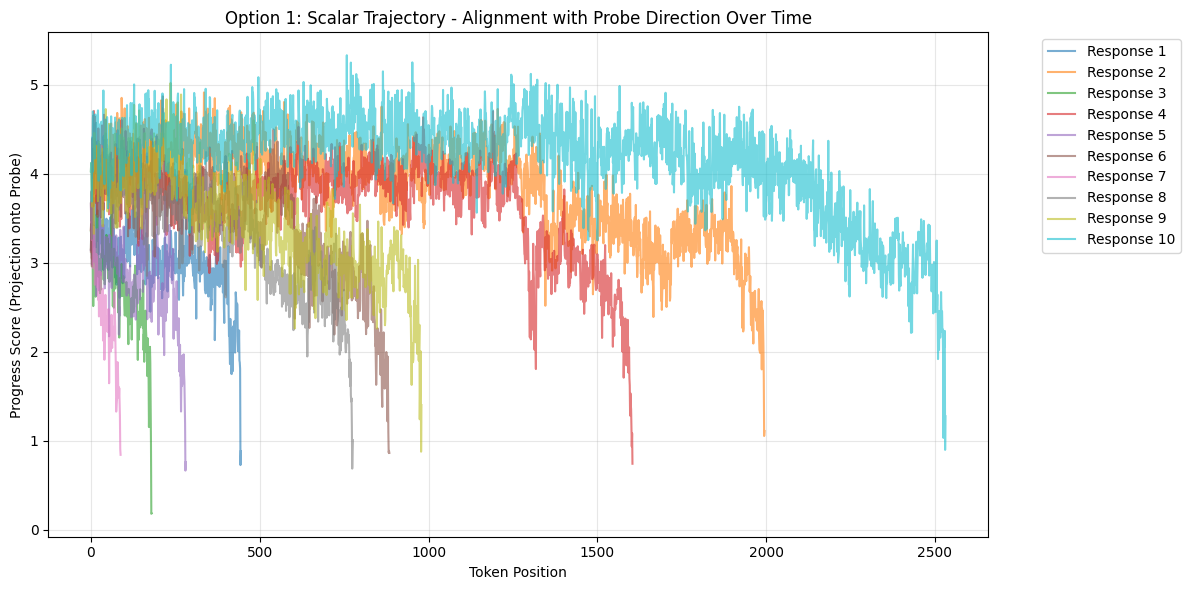

In [30]:
# Compute scalar trajectories for multiple responses
num_samples_to_plot = min(10, len(activations))

plt.figure(figsize=(12, 6))

for i in range(num_samples_to_plot):
    # Get residual stream for this response
    residual_stream = activations[i].activations[0].to(torch.float32)  # shape: [seq_len, d_model]
    
    # Compute progress scores using lin_to_lin probe
    progress_scores = compute_scalar_trajectory(residual_stream, balanced_lin_to_log_betas)
    
    # Plot the trajectory
    plt.plot(progress_scores.cpu().numpy(), alpha=0.6, label=f'Response {i+1}')

plt.xlabel('Token Position')
plt.ylabel('Progress Score (Projection onto Probe)')
plt.title('Option 1: Scalar Trajectory - Alignment with Probe Direction Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Option 2: 2D/3D Visualization with PCA and Probe Reference

In [31]:
from sklearn.decomposition import PCA

def prepare_pca_visualization(activations_list, probe_direction, n_components=2, max_samples=50):
    """
    Prepare data for PCA visualization with probe direction as reference.
    
    Args:
        activations_list: list of activation objects
        probe_direction: tensor of shape [d_model]
        n_components: 2 or 3 for dimensionality reduction
        max_samples: maximum number of samples to include
    
    Returns:
        pca: fitted PCA object
        trajectories_pca: list of transformed trajectories
        probe_line_pca: probe direction trajectory in PCA space
        token_positions: list of token positions for each trajectory
    """
    # Collect all residual streams
    all_residuals = []
    trajectory_lens = []
    
    for i, act in enumerate(activations_list[:max_samples]):
        residual_f32 = act.activations[0].float()
        all_residuals.append(residual_f32)
        trajectory_lens.append(residual_f32.shape[0])
    
    # Concatenate all residuals for PCA fitting
    all_residuals_concat = torch.cat(all_residuals, dim=0).cpu().numpy()
    
    # Fit PCA
    pca = PCA(n_components=n_components)
    pca.fit(all_residuals_concat)
    
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")
    
    # Transform each trajectory separately
    trajectories_pca = []
    token_positions = []
    start_idx = 0
    
    for traj_len in trajectory_lens:
        traj_pca = all_residuals_concat[start_idx:start_idx+traj_len]
        trajectories_pca.append(pca.transform(traj_pca))
        token_positions.append(np.arange(traj_len))
        start_idx += traj_len
    
    # Transform probe direction into PCA space
    # Create a line: [0.1×probe, 0.2×probe, ..., 1.0×probe]
    probe_scales = np.linspace(0.1, 1.0, 10)
    probe_direction_np = probe_direction.cpu().numpy()
    probe_line = np.array([scale * probe_direction_np for scale in probe_scales])
    probe_line_pca = pca.transform(probe_line)
    
    return pca, trajectories_pca, probe_line_pca, token_positions

PCA explained variance ratio: [0.04039472 0.03246764]
Total variance explained: 0.0729


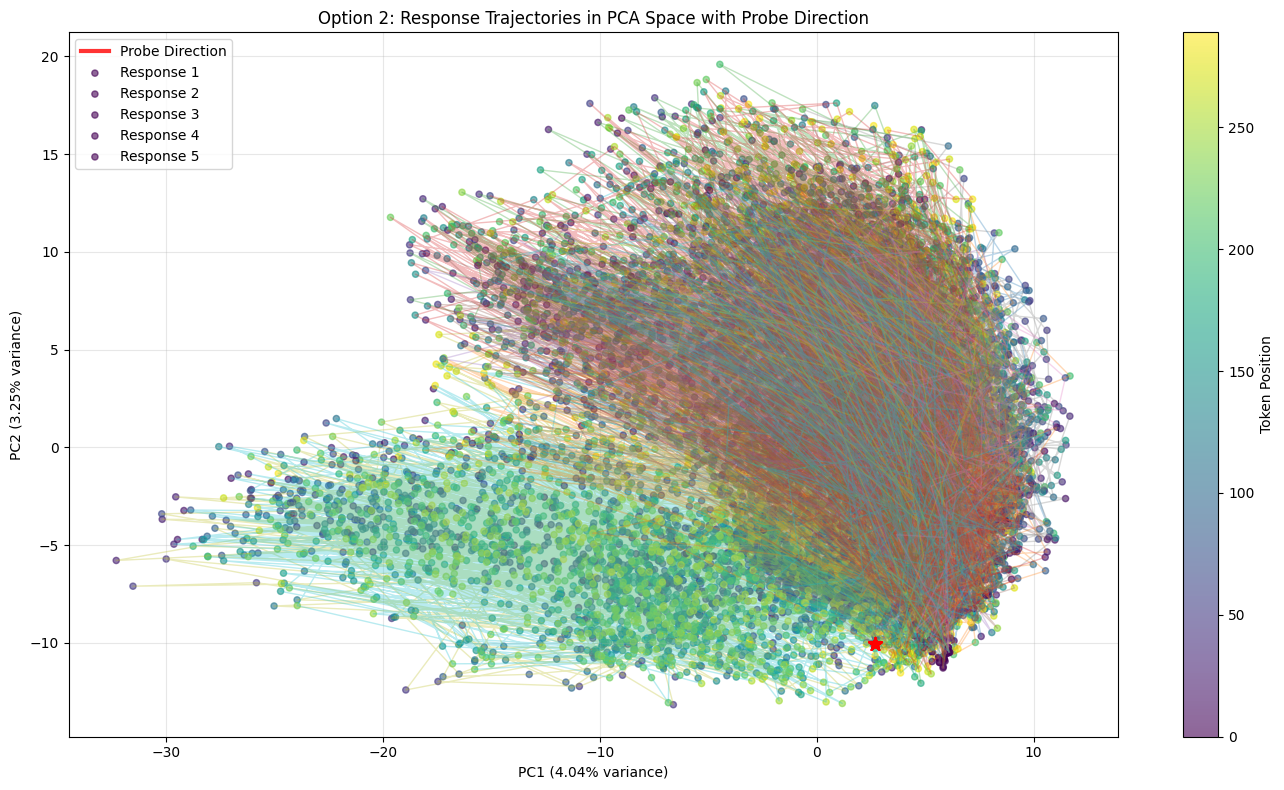

In [47]:
# Prepare PCA visualization (2D)
pca_2d, trajectories_2d, probe_line_2d, token_pos = prepare_pca_visualization(
    activations, balanced_lin_to_log_betas, n_components=2, max_samples=20
)

# Plot 2D trajectories
plt.figure(figsize=(14, 8))

# Plot the probe direction line
plt.plot(probe_line_2d[:, 0], probe_line_2d[:, 1], 
         'r-', linewidth=3, alpha=0.8, label='Probe Direction', zorder=10)
plt.scatter(probe_line_2d[:, 0], probe_line_2d[:, 1], 
           c='red', s=100, marker='*', zorder=11)

# Plot each response trajectory
cmap = plt.cm.viridis
for i, (traj, tok_pos) in enumerate(zip(trajectories_2d, token_pos)):
    # Color by token position (time)
    colors = cmap(tok_pos / tok_pos.max())
    plt.scatter(traj[:, 0], traj[:, 1], c=tok_pos, cmap='viridis', 
               alpha=0.6, s=20, label=f'Response {i+1}' if i < 5 else None)
    # Draw line connecting tokens
    plt.plot(traj[:, 0], traj[:, 1], alpha=0.3, linewidth=1)

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Option 2: Response Trajectories in PCA Space with Probe Direction')
plt.colorbar(label='Token Position')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

PCA explained variance ratio: [0.04340888 0.03350991 0.02336165]
Total variance explained: 0.1003


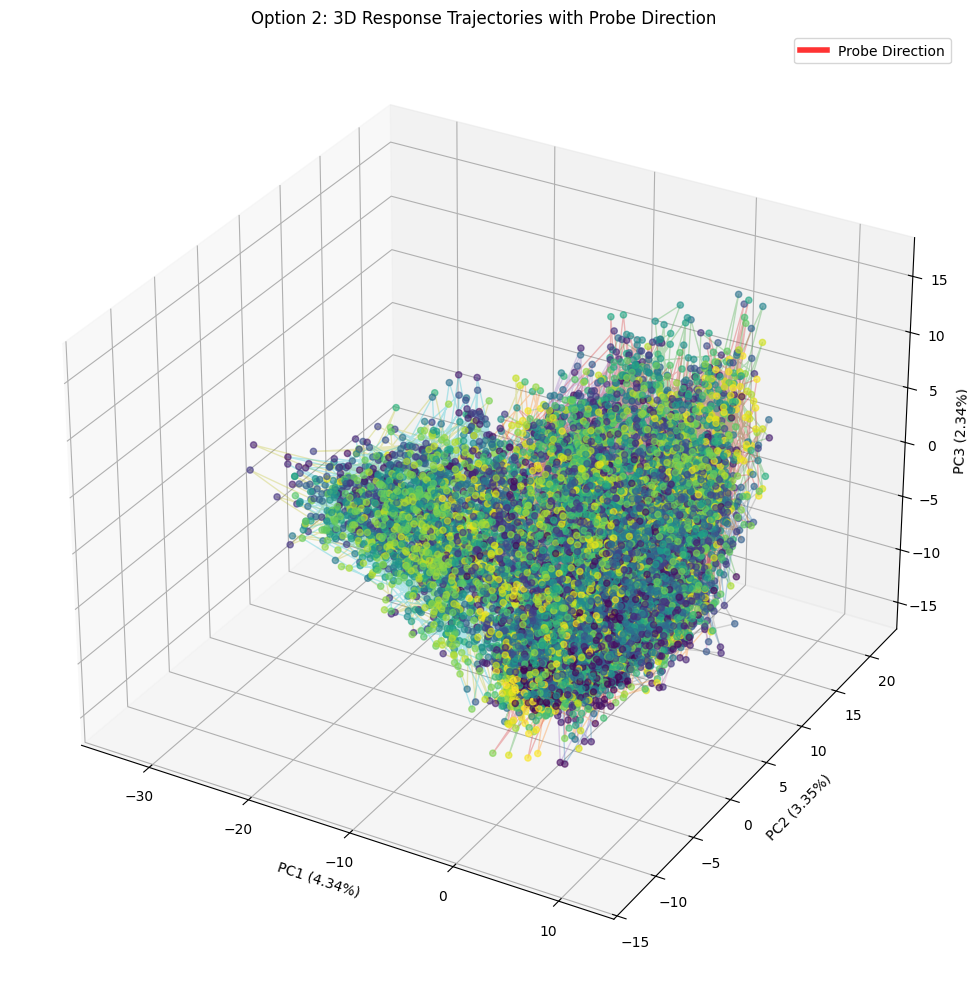

In [59]:
# Prepare 3D PCA visualization
pca_3d, trajectories_3d, probe_line_3d, token_pos_3d = prepare_pca_visualization(
    activations, balanced_lin_to_log_betas, n_components=3, max_samples=15
)

# Plot 3D trajectories
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the probe direction line
ax.plot(probe_line_3d[:, 0], probe_line_3d[:, 1], probe_line_3d[:, 2],
        'r-', linewidth=4, alpha=0.8, label='Probe Direction')
ax.scatter(probe_line_3d[:, 0], probe_line_3d[:, 1], probe_line_3d[:, 2],
          c='red', s=200, marker='*', depthshade=False)

# Plot each response trajectory
cmap = plt.cm.viridis
for i, (traj, tok_pos) in enumerate(zip(trajectories_3d, token_pos_3d)):
    # Color by token position
    colors = cmap(tok_pos / tok_pos.max())
    ax.scatter(traj[:, 0], traj[:, 1], traj[:, 2], 
              c=tok_pos, cmap='viridis', alpha=0.6, s=20)
    # Draw line connecting tokens
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.3, linewidth=1)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax.set_title('Option 2: 3D Response Trajectories with Probe Direction')
ax.legend()
plt.tight_layout()
plt.show()

# Option 3: Deviation from Probe Direction (Progress vs Orthogonal Deviation)

In [48]:
def compute_probe_decomposition(residual_stream, probe_direction):
    """
    Decompose residual stream into two components:
    1. Projection along probe direction (progress)
    2. Orthogonal component (deviation/noise)
    
    Args:
        residual_stream: tensor of shape [seq_len, d_model] (bfloat16)
        probe_direction: tensor of shape [d_model] (float32)
    
    Returns:
        proj_probe: projection along probe direction [seq_len]
        proj_orthogonal: magnitude of orthogonal component [seq_len]
    """
    # Convert to float32
    residual_f32 = residual_stream.float()
    
    # Normalize probe direction
    probe_normalized = probe_direction / torch.norm(probe_direction)
    
    # Compute projection along probe (progress component)
    proj_probe = einsum(residual_f32, probe_normalized, "seq d, d -> seq")
    
    # Compute the component along the probe direction
    probe_component = einsum(proj_probe, probe_normalized, "seq, d -> seq d")
    
    # Compute orthogonal component (residual - projection)
    orthogonal_component = residual_f32 - probe_component
    
    # Compute magnitude of orthogonal component
    proj_orthogonal = torch.norm(orthogonal_component, dim=1)
    
    return proj_probe, proj_orthogonal

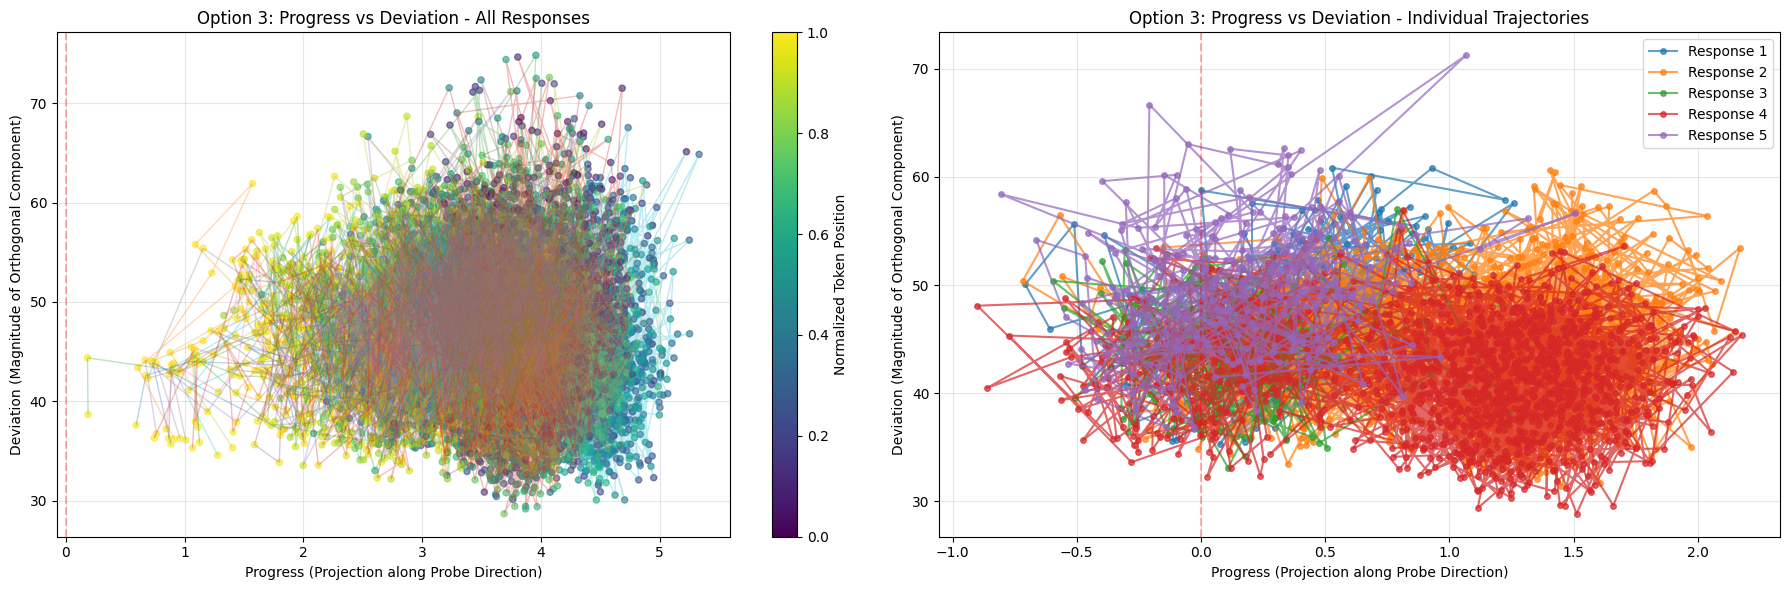

In [49]:
# Compute probe decomposition for multiple responses
num_samples_for_decomp = min(15, len(activations))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Trajectories in Progress vs Deviation space
ax1 = axes[0]
cmap = plt.cm.viridis

for i in range(num_samples_for_decomp):
    residual_stream = activations[i].activations[0]
    proj_probe, proj_orthogonal = compute_probe_decomposition(residual_stream, balanced_lin_to_log_betas)
    
    # Convert to numpy
    proj_probe_np = proj_probe.cpu().numpy()
    proj_orthogonal_np = proj_orthogonal.cpu().numpy()
    token_indices = np.arange(len(proj_probe_np))
    
    # Color by token position
    colors = cmap(token_indices / token_indices.max())
    
    # Plot trajectory
    ax1.scatter(proj_probe_np, proj_orthogonal_np, c=token_indices, cmap='viridis', 
               alpha=0.6, s=20, vmin=0, vmax=token_indices.max())
    ax1.plot(proj_probe_np, proj_orthogonal_np, alpha=0.3, linewidth=1)

ax1.set_xlabel('Progress (Projection along Probe Direction)')
ax1.set_ylabel('Deviation (Magnitude of Orthogonal Component)')
ax1.set_title('Option 3: Progress vs Deviation - All Responses')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.3, label='Zero progress')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, label='Normalized Token Position')

# Plot 2: Individual trajectories
ax2 = axes[1]
n_to_plot_individually = min(5, num_samples_for_decomp)

for i in range(n_to_plot_individually):
    residual_stream = activations[i].activations[0]
    proj_probe, proj_orthogonal = compute_probe_decomposition(residual_stream, balanced_lin_to_lin_betas)
    
    proj_probe_np = proj_probe.cpu().numpy()
    proj_orthogonal_np = proj_orthogonal.cpu().numpy()
    
    ax2.plot(proj_probe_np, proj_orthogonal_np, marker='o', alpha=0.7, 
            label=f'Response {i+1}', markersize=4)

ax2.set_xlabel('Progress (Projection along Probe Direction)')
ax2.set_ylabel('Deviation (Magnitude of Orthogonal Component)')
ax2.set_title('Option 3: Progress vs Deviation - Individual Trajectories')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## Additional Analysis: Progress over time for Option 3

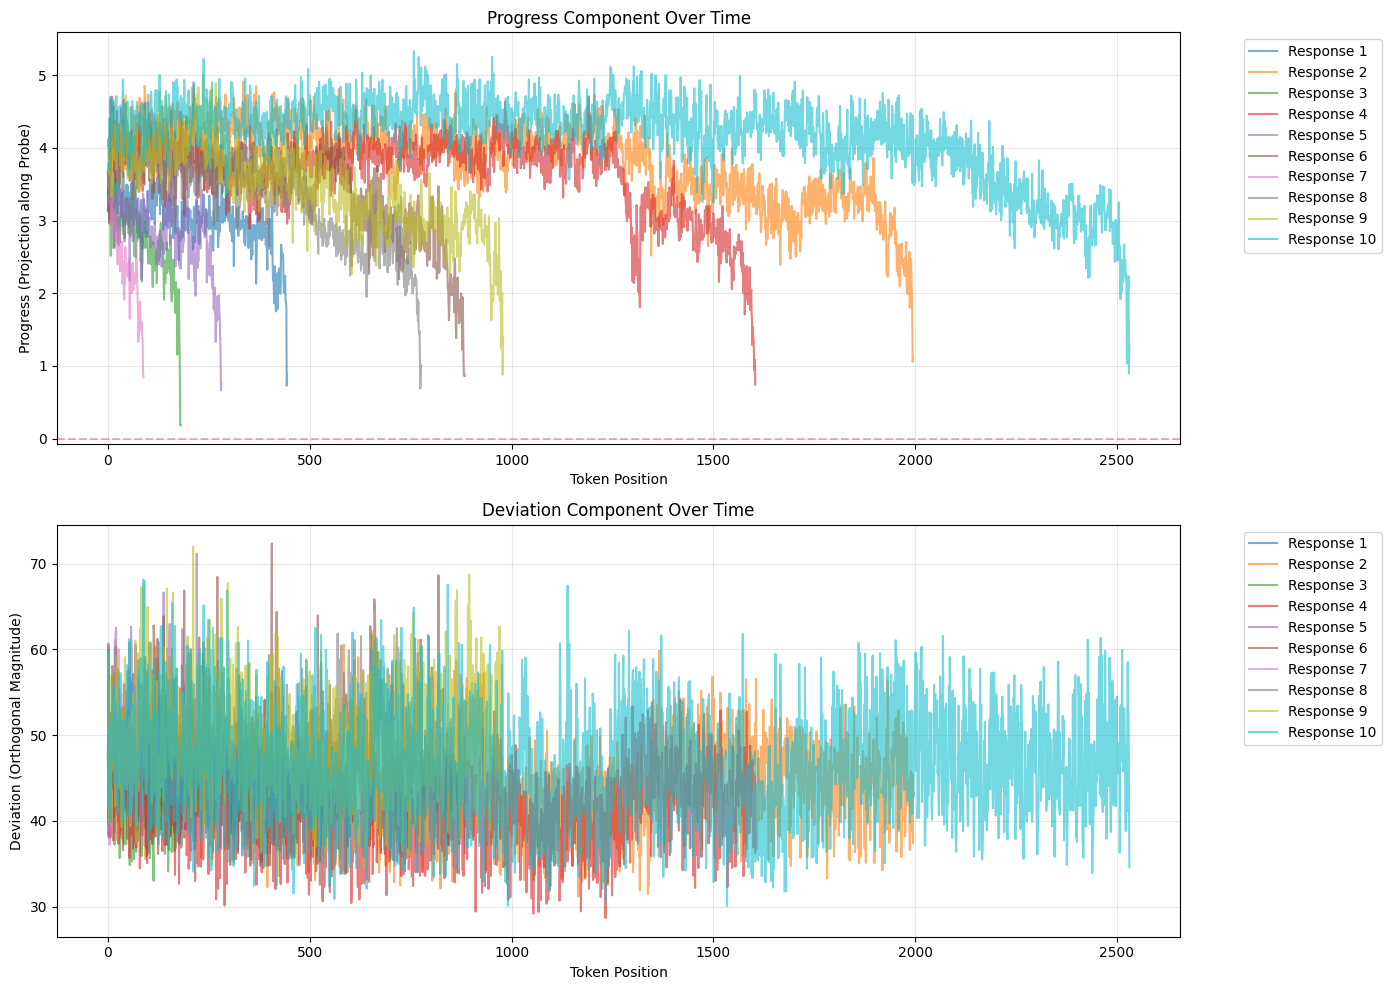

In [51]:
# Show how progress and deviation evolve over token position
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

n_to_analyze = min(10, len(activations))

# Plot 1: Progress over token position
ax1 = axes[0]
for i in range(n_to_analyze):
    residual_stream = activations[i].activations[0]
    proj_probe, proj_orthogonal = compute_probe_decomposition(residual_stream, balanced_lin_to_log_betas)
    
    token_positions = np.arange(len(proj_probe))
    ax1.plot(token_positions, proj_probe.cpu().numpy(), alpha=0.6, label=f'Response {i+1}')

ax1.set_xlabel('Token Position')
ax1.set_ylabel('Progress (Projection along Probe)')
ax1.set_title('Progress Component Over Time')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.3)

# Plot 2: Deviation over token position
ax2 = axes[1]
for i in range(n_to_analyze):
    residual_stream = activations[i].activations[0]
    proj_probe, proj_orthogonal = compute_probe_decomposition(residual_stream, balanced_lin_to_log_betas)
    
    token_positions = np.arange(len(proj_orthogonal))
    ax2.plot(token_positions, proj_orthogonal.cpu().numpy(), alpha=0.6, label=f'Response {i+1}')

ax2.set_xlabel('Token Position')
ax2.set_ylabel('Deviation (Orthogonal Magnitude)')
ax2.set_title('Deviation Component Over Time')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

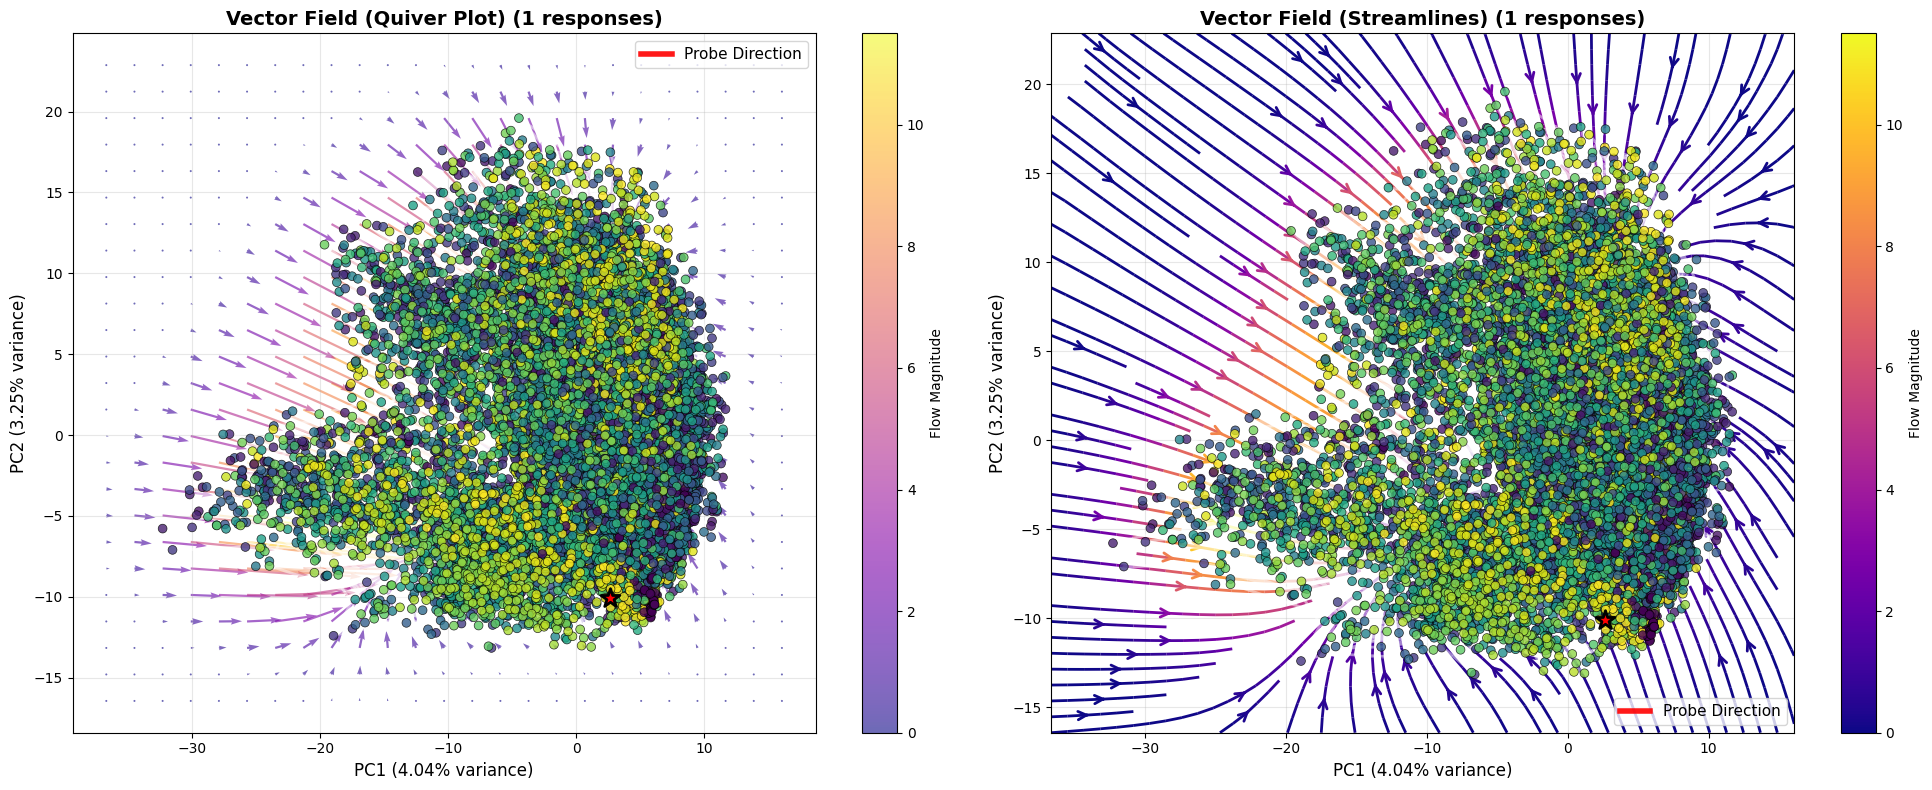

In [66]:
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

def compute_vector_field(trajectories_pca, grid_resolution=20, smoothing_sigma=1.0, min_samples=3):
    """
    Compute vector field showing the flow of token representations.
    
    Args:
        trajectories_pca: list of numpy arrays, each of shape [seq_len, n_components]
        grid_resolution: number of grid points along each axis
        smoothing_sigma: gaussian smoothing parameter for the field
        min_samples: minimum samples needed in a region to compute flow
    
    Returns:
        X, Y: meshgrid coordinates
        U, V: flow vectors at each grid point
        positions: all token positions [N, 2]
        deltas: all token-to-token movements [N, 2]
    """
    # Collect all positions and their deltas (where they move next)
    positions = []
    deltas = []
    
    for traj in trajectories_pca:
        if len(traj) < 2:
            continue
        positions.append(traj[:-1])  # All but last token
        deltas.append(traj[1:] - traj[:-1])  # Movement to next token
    
    positions = np.vstack(positions)
    deltas = np.vstack(deltas)
    
    # Create grid
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
    
    # Add padding
    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1
    
    x = np.linspace(x_min - x_padding, x_max + x_padding, grid_resolution)
    y = np.linspace(y_min - y_padding, y_max + y_padding, grid_resolution)
    X, Y = np.meshgrid(x, y)
    
    # Interpolate flow field using griddata
    # This averages nearby deltas for each grid point
    U = griddata(positions, deltas[:, 0], (X, Y), method='linear', fill_value=0)
    V = griddata(positions, deltas[:, 1], (X, Y), method='linear', fill_value=0)
    
    # Apply gaussian smoothing to reduce noise
    U = gaussian_filter(U, sigma=smoothing_sigma)
    V = gaussian_filter(V, sigma=smoothing_sigma)
    
    return X, Y, U, V, positions, deltas


def plot_vector_field_with_trajectories(trajectories_pca, probe_line_pca, token_positions, 
                                         pca, title_suffix="", max_trajectories=10):
    """
    Plot vector field with response trajectories overlaid.
    """
    # Compute vector field
    X, Y, U, V, positions, deltas = compute_vector_field(
        trajectories_pca[:max_trajectories], 
        grid_resolution=25,
        smoothing_sigma=1.5
    )
    
    # Compute flow magnitude for coloring
    flow_magnitude = np.sqrt(U**2 + V**2)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # ===== LEFT PLOT: Quiver (arrow) plot =====
    ax1 = axes[0]
    
    # Plot vector field as arrows
    # Normalize arrow lengths for visibility
    quiver = ax1.quiver(X, Y, U, V, flow_magnitude, 
                        cmap='plasma', alpha=0.6, scale=50, width=0.003)
    
    # Plot probe direction
    ax1.plot(probe_line_pca[:, 0], probe_line_pca[:, 1], 
             'r-', linewidth=4, alpha=0.9, label='Probe Direction', zorder=10)
    ax1.scatter(probe_line_pca[-1, 0], probe_line_pca[-1, 1], 
               c='red', s=200, marker='*', zorder=11, edgecolors='black', linewidths=2)
    
    # Plot response trajectories
    cmap = plt.cm.viridis
    for i, (traj, tok_pos) in enumerate(zip(trajectories_pca[:max_trajectories], 
                                             token_positions[:max_trajectories])):
        ax1.plot(traj[:, 0], traj[:, 1], alpha=0.5, linewidth=2, color='white', zorder=5)
        scatter = ax1.scatter(traj[:, 0], traj[:, 1], c=tok_pos, cmap='viridis', 
                             alpha=0.8, s=40, zorder=6, edgecolors='black', linewidths=0.5)
    
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
    ax1.set_title(f'Vector Field (Quiver Plot) {title_suffix}', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, loc='best')
    ax1.grid(True, alpha=0.3)
    
    plt.colorbar(quiver, ax=ax1, label='Flow Magnitude')
    
    # ===== RIGHT PLOT: Streamline plot =====
    ax2 = axes[1]
    
    # Plot streamlines
    streamplot = ax2.streamplot(X, Y, U, V, color=flow_magnitude, 
                                 cmap='plasma', linewidth=2, density=1.5, 
                                 arrowsize=1.5, arrowstyle='->')
    
    # Plot probe direction
    ax2.plot(probe_line_pca[:, 0], probe_line_pca[:, 1], 
             'r-', linewidth=4, alpha=0.9, label='Probe Direction', zorder=10)
    ax2.scatter(probe_line_pca[-1, 0], probe_line_pca[-1, 1], 
               c='red', s=200, marker='*', zorder=11, edgecolors='black', linewidths=2)
    
    # Plot response trajectories
    for i, (traj, tok_pos) in enumerate(zip(trajectories_pca[:max_trajectories], 
                                             token_positions[:max_trajectories])):
        ax2.plot(traj[:, 0], traj[:, 1], alpha=0.5, linewidth=2, color='white', zorder=5)
        ax2.scatter(traj[:, 0], traj[:, 1], c=tok_pos, cmap='viridis', 
                   alpha=0.8, s=40, zorder=6, edgecolors='black', linewidths=0.5)
    
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
    ax2.set_title(f'Vector Field (Streamlines) {title_suffix}', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11, loc='best')
    ax2.grid(True, alpha=0.3)
    
    plt.colorbar(streamplot.lines, ax=ax2, label='Flow Magnitude')
    
    plt.tight_layout()
    plt.show()
    
    return X, Y, U, V


# Generate the vector field visualization
X, Y, U, V = plot_vector_field_with_trajectories(
    trajectories_2d, 
    probe_line_2d, 
    token_pos, 
    pca_2d,
    title_suffix="(1 responses)",
    max_trajectories=100
)

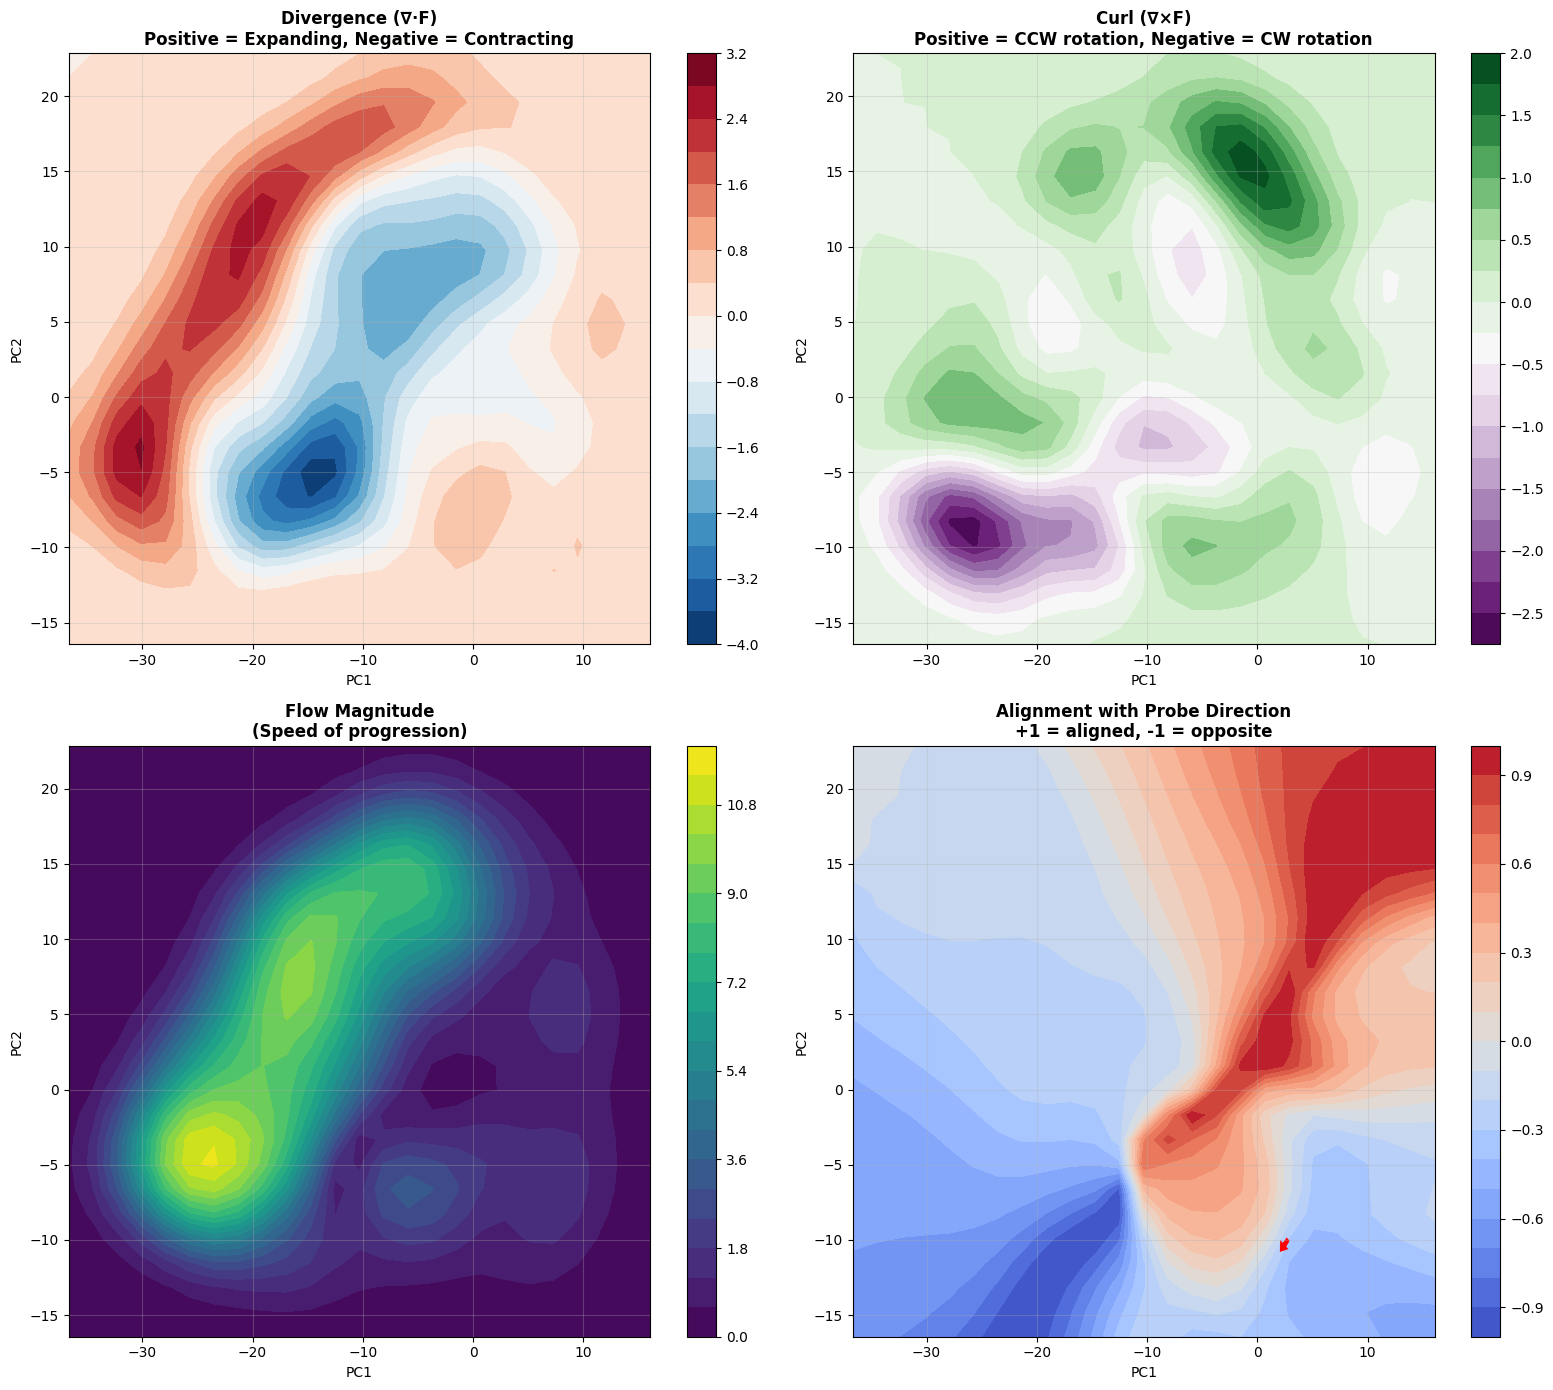

VECTOR FIELD STATISTICS
Average divergence: 0.000345
  (negative = net contraction toward completion)

Average curl magnitude: 0.351938
  (zero = no rotation, high = rotational dynamics)

Average flow magnitude: 2.348675

Average alignment with probe: -0.0378
  (range: -1 to +1, where +1 = perfect alignment)

Alignment statistics:
  - % aligned (>0.5): 16.5%
  - % opposed (<-0.5): 16.2%


In [53]:
def analyze_vector_field(X, Y, U, V, probe_direction_pca):
    """
    Analyze properties of the vector field.
    
    Returns statistics about divergence, curl, and alignment with probe.
    """
    # Compute derivatives for divergence and curl
    dU_dx = np.gradient(U, axis=1)
    dV_dy = np.gradient(V, axis=0)
    dU_dy = np.gradient(U, axis=0)
    dV_dx = np.gradient(V, axis=1)
    
    # Divergence: ∇·F = ∂U/∂x + ∂V/∂y
    divergence = dU_dx + dV_dy
    
    # Curl (2D): ∇×F = ∂V/∂x - ∂U/∂y (z-component only)
    curl = dV_dx - dU_dy
    
    # Flow magnitude
    magnitude = np.sqrt(U**2 + V**2)
    
    # Alignment with probe direction
    # Get the probe direction in PCA space (just the direction vector)
    probe_dir = probe_direction_pca[-1] - probe_direction_pca[0]
    probe_dir_norm = probe_dir / np.linalg.norm(probe_dir)
    
    # Compute dot product at each point
    flow_vectors = np.stack([U, V], axis=-1)
    flow_vectors_norm = flow_vectors / (magnitude[..., None] + 1e-8)
    alignment = np.sum(flow_vectors_norm * probe_dir_norm, axis=-1)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Divergence
    im1 = axes[0, 0].contourf(X, Y, divergence, levels=20, cmap='RdBu_r')
    axes[0, 0].set_title('Divergence (∇·F)\nPositive = Expanding, Negative = Contracting', 
                         fontweight='bold')
    axes[0, 0].set_xlabel('PC1')
    axes[0, 0].set_ylabel('PC2')
    plt.colorbar(im1, ax=axes[0, 0])
    axes[0, 0].grid(True, alpha=0.3)
    
    # Curl
    im2 = axes[0, 1].contourf(X, Y, curl, levels=20, cmap='PRGn')
    axes[0, 1].set_title('Curl (∇×F)\nPositive = CCW rotation, Negative = CW rotation', 
                         fontweight='bold')
    axes[0, 1].set_xlabel('PC1')
    axes[0, 1].set_ylabel('PC2')
    plt.colorbar(im2, ax=axes[0, 1])
    axes[0, 1].grid(True, alpha=0.3)
    
    # Magnitude
    im3 = axes[1, 0].contourf(X, Y, magnitude, levels=20, cmap='viridis')
    axes[1, 0].set_title('Flow Magnitude\n(Speed of progression)', fontweight='bold')
    axes[1, 0].set_xlabel('PC1')
    axes[1, 0].set_ylabel('PC2')
    plt.colorbar(im3, ax=axes[1, 0])
    axes[1, 0].grid(True, alpha=0.3)
    
    # Alignment with probe
    im4 = axes[1, 1].contourf(X, Y, alignment, levels=20, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1, 1].set_title('Alignment with Probe Direction\n+1 = aligned, -1 = opposite', 
                         fontweight='bold')
    axes[1, 1].set_xlabel('PC1')
    axes[1, 1].set_ylabel('PC2')
    
    # Overlay probe direction as arrow
    probe_center = probe_direction_pca[len(probe_direction_pca)//2]
    probe_delta = probe_dir_norm * 0.5  # Scale for visibility
    axes[1, 1].arrow(probe_center[0], probe_center[1], 
                    probe_delta[0], probe_delta[1],
                    head_width=0.3, head_length=0.2, fc='red', ec='red', linewidth=3)
    
    plt.colorbar(im4, ax=axes[1, 1])
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("=" * 60)
    print("VECTOR FIELD STATISTICS")
    print("=" * 60)
    print(f"Average divergence: {np.nanmean(divergence):.6f}")
    print(f"  (negative = net contraction toward completion)")
    print(f"\nAverage curl magnitude: {np.nanmean(np.abs(curl)):.6f}")
    print(f"  (zero = no rotation, high = rotational dynamics)")
    print(f"\nAverage flow magnitude: {np.nanmean(magnitude):.6f}")
    print(f"\nAverage alignment with probe: {np.nanmean(alignment):.4f}")
    print(f"  (range: -1 to +1, where +1 = perfect alignment)")
    print(f"\nAlignment statistics:")
    print(f"  - % aligned (>0.5): {100 * np.mean(alignment > 0.5):.1f}%")
    print(f"  - % opposed (<-0.5): {100 * np.mean(alignment < -0.5):.1f}%")
    print("=" * 60)
    
    return {
        'divergence': divergence,
        'curl': curl,
        'magnitude': magnitude,
        'alignment': alignment
    }


# Run the analysis
stats = analyze_vector_field(X, Y, U, V, probe_line_2d)

# Interactive 3D Visualizations with Plotly

In [55]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import nbformat

## 1. Interactive 3D Trajectories with Probe Direction

In [58]:
# Interactive 3D trajectory plot
fig = go.Figure()

# Add probe direction line
fig.add_trace(go.Scatter3d(
    x=probe_line_3d[:, 0],
    y=probe_line_3d[:, 1],
    z=probe_line_3d[:, 2],
    mode='lines+markers',
    name='Probe Direction',
    line=dict(color='red', width=8),
    marker=dict(size=8, color='red', symbol='diamond')
))

# Add response trajectories
num_to_plot = min(3, len(trajectories_3d))
colors_plotly = px.colors.qualitative.Plotly + px.colors.qualitative.Set2

for i, (traj, tok_pos) in enumerate(zip(trajectories_3d[:num_to_plot], token_pos_3d[:num_to_plot])):
    # Create color scale based on token position
    color_vals = tok_pos / tok_pos.max()
    
    fig.add_trace(go.Scatter3d(
        x=traj[:, 0],
        y=traj[:, 1],
        z=traj[:, 2],
        mode='lines+markers',
        name=f'Response {i+1}',
        line=dict(width=3, color=colors_plotly[i % len(colors_plotly)]),
        marker=dict(
            size=4,
            color=tok_pos,
            colorscale='Viridis',
            showscale=(i == 0),  # Show colorbar only for first trace
            colorbar=dict(title="Token Position", x=1.1) if i == 0 else None,
            cmin=0,
            cmax=max([tp.max() for tp in token_pos_3d[:num_to_plot]])
        ),
        hovertemplate='<b>Response %{fullData.name}</b><br>' +
                      'PC1: %{x:.2f}<br>' +
                      'PC2: %{y:.2f}<br>' +
                      'PC3: %{z:.2f}<br>' +
                      'Token: %{marker.color:.0f}<extra></extra>'
    ))

fig.update_layout(
    title=dict(
        text='Interactive 3D Response Trajectories with Probe Direction',
        font=dict(size=18, family='Arial Black')
    ),
    scene=dict(
        xaxis=dict(title=f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})'),
        yaxis=dict(title=f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})'),
        zaxis=dict(title=f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})'),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    ),
    width=1000,
    height=800,
    showlegend=True,
    hovermode='closest'
)

fig.show()

## 2. Interactive 3D Progress vs Deviation (with height as time)

In [62]:
# 3D Progress vs Deviation with token position as Z-axis
fig = go.Figure()

num_samples_3d = min(1, len(activations))

for i in range(num_samples_3d):
    residual_stream = activations[i].activations[0]
    proj_probe, proj_orthogonal = compute_probe_decomposition(residual_stream, balanced_lin_to_log_betas)
    
    proj_probe_np = proj_probe.cpu().numpy()
    proj_orthogonal_np = proj_orthogonal.cpu().numpy()
    token_indices = np.arange(len(proj_probe_np))
    
    fig.add_trace(go.Scatter3d(
        x=proj_probe_np,
        y=proj_orthogonal_np,
        z=token_indices,
        mode='lines+markers',
        name=f'Response {i+1}',
        line=dict(width=3, color=colors_plotly[i % len(colors_plotly)]),
        marker=dict(
            size=4,
            color=token_indices,
            colorscale='Viridis',
            showscale=(i == 0),
            colorbar=dict(title="Token Position", x=1.1) if i == 0 else None
        ),
        hovertemplate='<b>Response %{fullData.name}</b><br>' +
                      'Progress: %{x:.2f}<br>' +
                      'Deviation: %{y:.2f}<br>' +
                      'Token Position: %{z:.0f}<extra></extra>'
    ))

# Add zero progress plane
fig.add_trace(go.Scatter3d(
    x=[0, 0],
    y=[0, max([proj_orthogonal.cpu().numpy().max() for _ in range(1)])],
    z=[0, max([len(activations[i].activations[0]) for i in range(num_samples_3d)])],
    mode='lines',
    name='Zero Progress',
    line=dict(color='red', width=2, dash='dash'),
    showlegend=True
))

fig.update_layout(
    title=dict(
        text='3D Progress vs Deviation Over Time',
        font=dict(size=18, family='Arial Black')
    ),
    scene=dict(
        xaxis=dict(title='Progress (along probe)'),
        yaxis=dict(title='Deviation (orthogonal)'),
        zaxis=dict(title='Token Position (time)'),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.2)
        )
    ),
    width=1000,
    height=800,
    showlegend=True,
    hovermode='closest'
)

fig.show()

## 3. Interactive 3D Vector Field with Cone Plot

In [64]:
# Create 3D vector field using cone plot
# Use a coarser grid for 3D visualization
X_3d, Y_3d, U_3d, V_3d, positions_3d, deltas_3d = compute_vector_field(
    trajectories_2d[:1], 
    grid_resolution=15,
    smoothing_sigma=1.5
)

# Calculate flow magnitude
flow_mag = np.sqrt(U_3d**2 + V_3d**2)

fig = go.Figure()

# Add 3D cone plot (arrows showing direction)
# Sample every other point to avoid overcrowding
sample_step = 2
X_sample = X_3d[::sample_step, ::sample_step]
Y_sample = Y_3d[::sample_step, ::sample_step]
U_sample = U_3d[::sample_step, ::sample_step]
V_sample = V_3d[::sample_step, ::sample_step]
mag_sample = flow_mag[::sample_step, ::sample_step]

# Flatten for plotting
X_flat = X_sample.flatten()
Y_flat = Y_sample.flatten()
U_flat = U_sample.flatten()
V_flat = V_sample.flatten()
mag_flat = mag_sample.flatten()

fig.add_trace(go.Cone(
    x=X_flat,
    y=Y_flat,
    z=np.zeros_like(X_flat),  # All at z=0
    u=U_flat,
    v=V_flat,
    w=np.zeros_like(U_flat),  # No z-component
    colorscale='Plasma',
    sizemode='absolute',
    sizeref=0.3,
    showscale=True,
    colorbar=dict(title="Flow Magnitude", x=1.1),
    name='Vector Field',
    hovertemplate='Position: (%{x:.2f}, %{y:.2f})<br>' +
                  'Flow: (%{u:.2f}, %{v:.2f})<extra></extra>'
))

# Add probe direction
fig.add_trace(go.Scatter3d(
    x=probe_line_2d[:, 0],
    y=probe_line_2d[:, 1],
    z=np.zeros(len(probe_line_2d)),
    mode='lines+markers',
    name='Probe Direction',
    line=dict(color='red', width=10),
    marker=dict(size=8, color='red', symbol='diamond')
))

# Add sample trajectories
for i in range(min(5, len(trajectories_2d))):
    traj = trajectories_2d[i]
    fig.add_trace(go.Scatter3d(
        x=traj[:, 0],
        y=traj[:, 1],
        z=np.zeros(len(traj)),
        mode='lines',
        name=f'Response {i+1}',
        line=dict(width=4, color=colors_plotly[i % len(colors_plotly)]),
        opacity=0.7
    ))

fig.update_layout(
    title=dict(
        text='Interactive 3D Vector Field (Cone Plot)',
        font=dict(size=18, family='Arial Black')
    ),
    scene=dict(
        xaxis=dict(title=f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})'),
        yaxis=dict(title=f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})'),
        zaxis=dict(title='', showticklabels=False, showgrid=False),
        camera=dict(
            eye=dict(x=0, y=0, z=2.5)  # Top-down view
        ),
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.1)
    ),
    width=1000,
    height=800,
    showlegend=True
)

fig.show()

## 4. Interactive 3D Surface Plots for Vector Field Properties

In [67]:
# Create 4 interactive 3D surface plots for vector field analysis
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Divergence (Contraction/Expansion)', 
                    'Curl (Rotation)', 
                    'Flow Magnitude (Speed)', 
                    'Alignment with Probe'),
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]],
    vertical_spacing=0.1,
    horizontal_spacing=0.1
)

# Divergence
fig.add_trace(
    go.Surface(
        x=X,
        y=Y,
        z=stats['divergence'],
        colorscale='RdBu_r',
        name='Divergence',
        colorbar=dict(x=0.45, len=0.4, y=0.75, title='Divergence'),
        hovertemplate='PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>Divergence: %{z:.4f}<extra></extra>'
    ),
    row=1, col=1
)

# Curl
fig.add_trace(
    go.Surface(
        x=X,
        y=Y,
        z=stats['curl'],
        colorscale='PRGn',
        name='Curl',
        colorbar=dict(x=1.02, len=0.4, y=0.75, title='Curl'),
        hovertemplate='PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>Curl: %{z:.4f}<extra></extra>'
    ),
    row=1, col=2
)

# Magnitude
fig.add_trace(
    go.Surface(
        x=X,
        y=Y,
        z=stats['magnitude'],
        colorscale='Viridis',
        name='Magnitude',
        colorbar=dict(x=0.45, len=0.4, y=0.25, title='Magnitude'),
        hovertemplate='PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>Magnitude: %{z:.4f}<extra></extra>'
    ),
    row=2, col=1
)

# Alignment
fig.add_trace(
    go.Surface(
        x=X,
        y=Y,
        z=stats['alignment'],
        colorscale='RdBu',
        name='Alignment',
        colorbar=dict(x=1.02, len=0.4, y=0.25, title='Alignment'),
        cmin=-1,
        cmax=1,
        hovertemplate='PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>Alignment: %{z:.4f}<extra></extra>'
    ),
    row=2, col=2
)

# Update layout
fig.update_layout(
    title=dict(
        text='Interactive 3D Vector Field Analysis',
        font=dict(size=18, family='Arial Black')
    ),
    height=1000,
    width=1400,
    showlegend=False
)

# Update all scene properties
for i in range(1, 5):
    row = (i - 1) // 2 + 1
    col = (i - 1) % 2 + 1
    fig.update_scenes(
        xaxis_title='PC1',
        yaxis_title='PC2',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3)),
        row=row, col=col
    )

fig.show()

## 5. Interactive Scalar Trajectory Plot (3D with height as progress)

In [68]:
# 3D visualization where token position is X-axis and progress score is height
fig = go.Figure()

num_samples_scalar = min(15, len(activations))

for i in range(num_samples_scalar):
    residual_stream = activations[i].activations[0]
    progress_scores = compute_scalar_trajectory(residual_stream, balanced_lin_to_log_betas)
    progress_np = progress_scores.cpu().numpy()
    token_positions = np.arange(len(progress_np))
    
    fig.add_trace(go.Scatter3d(
        x=token_positions,
        y=np.full_like(token_positions, i),  # Offset in Y for each response
        z=progress_np,
        mode='lines+markers',
        name=f'Response {i+1}',
        line=dict(width=3, color=colors_plotly[i % len(colors_plotly)]),
        marker=dict(
            size=3,
            color=progress_np,
            colorscale='Viridis',
            showscale=(i == 0),
            colorbar=dict(title="Progress Score", x=1.1) if i == 0 else None
        ),
        hovertemplate='<b>Response %{fullData.name}</b><br>' +
                      'Token: %{x:.0f}<br>' +
                      'Progress: %{z:.2f}<extra></extra>'
    ))

# Add zero plane
fig.add_trace(go.Mesh3d(
    x=[0, token_positions.max(), token_positions.max(), 0],
    y=[0, 0, num_samples_scalar, num_samples_scalar],
    z=[0, 0, 0, 0],
    opacity=0.2,
    color='red',
    name='Zero Progress Plane',
    hoverinfo='skip'
))

fig.update_layout(
    title=dict(
        text='Interactive 3D Scalar Progress Trajectories',
        font=dict(size=18, family='Arial Black')
    ),
    scene=dict(
        xaxis=dict(title='Token Position'),
        yaxis=dict(title='Response Index'),
        zaxis=dict(title='Progress Score (Projection onto Probe)'),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.2)
        )
    ),
    width=1000,
    height=800,
    showlegend=True,
    hovermode='closest'
)

fig.show()

## 6. Interactive Heatmap: Progress and Deviation Over Time

In [69]:
# Create heatmaps for progress and deviation across all responses
num_heatmap_samples = min(20, len(activations))
max_len = max([len(activations[i].activations[0]) for i in range(num_heatmap_samples)])

# Initialize matrices
progress_matrix = np.full((num_heatmap_samples, max_len), np.nan)
deviation_matrix = np.full((num_heatmap_samples, max_len), np.nan)

# Fill matrices
for i in range(num_heatmap_samples):
    residual_stream = activations[i].activations[0]
    proj_probe, proj_orthogonal = compute_probe_decomposition(residual_stream, balanced_lin_to_log_betas)
    
    length = len(proj_probe)
    progress_matrix[i, :length] = proj_probe.cpu().numpy()
    deviation_matrix[i, :length] = proj_orthogonal.cpu().numpy()

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Progress Component', 'Deviation Component'),
    specs=[[{'type': 'heatmap'}, {'type': 'heatmap'}]],
    horizontal_spacing=0.15
)

# Progress heatmap
fig.add_trace(
    go.Heatmap(
        z=progress_matrix,
        colorscale='RdBu',
        zmid=0,
        colorbar=dict(x=0.45, title='Progress'),
        hovertemplate='Response: %{y}<br>Token: %{x}<br>Progress: %{z:.2f}<extra></extra>',
        name='Progress'
    ),
    row=1, col=1
)

# Deviation heatmap
fig.add_trace(
    go.Heatmap(
        z=deviation_matrix,
        colorscale='Viridis',
        colorbar=dict(x=1.02, title='Deviation'),
        hovertemplate='Response: %{y}<br>Token: %{x}<br>Deviation: %{z:.2f}<extra></extra>',
        name='Deviation'
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="Token Position", row=1, col=1)
fig.update_xaxes(title_text="Token Position", row=1, col=2)
fig.update_yaxes(title_text="Response Index", row=1, col=1)
fig.update_yaxes(title_text="Response Index", row=1, col=2)

fig.update_layout(
    title=dict(
        text='Progress and Deviation Heatmaps Across Responses',
        font=dict(size=18, family='Arial Black')
    ),
    height=600,
    width=1400,
    showlegend=False
)

fig.show()

## 7. Interactive 3D Ribbon Plot: Trajectories with Width as Deviation

In [70]:
# 3D visualization showing trajectories where marker size represents deviation
fig = go.Figure()

num_ribbon_samples = min(10, len(activations))

for i in range(num_ribbon_samples):
    residual_stream = activations[i].activations[0]
    proj_probe, proj_orthogonal = compute_probe_decomposition(residual_stream, balanced_lin_to_lin_betas)
    
    proj_probe_np = proj_probe.cpu().numpy()
    proj_orthogonal_np = proj_orthogonal.cpu().numpy()
    token_positions = np.arange(len(proj_probe_np))
    
    # Normalize deviation for marker size (5-30 range)
    marker_sizes = 5 + 25 * (proj_orthogonal_np - proj_orthogonal_np.min()) / (proj_orthogonal_np.max() - proj_orthogonal_np.min() + 1e-8)
    
    fig.add_trace(go.Scatter3d(
        x=token_positions,
        y=proj_probe_np,
        z=proj_orthogonal_np,
        mode='lines+markers',
        name=f'Response {i+1}',
        line=dict(width=2, color=colors_plotly[i % len(colors_plotly)]),
        marker=dict(
            size=marker_sizes,
            color=proj_orthogonal_np,
            colorscale='Plasma',
            showscale=(i == 0),
            colorbar=dict(title="Deviation", x=1.1) if i == 0 else None,
            opacity=0.7,
            line=dict(width=0.5, color='white')
        ),
        hovertemplate='<b>Response %{fullData.name}</b><br>' +
                      'Token: %{x:.0f}<br>' +
                      'Progress: %{y:.2f}<br>' +
                      'Deviation: %{z:.2f}<extra></extra>'
    ))

# Add zero progress plane
fig.add_trace(go.Mesh3d(
    x=[0, token_positions.max(), token_positions.max(), 0],
    y=[0, 0, 0, 0],
    z=[0, 0, proj_orthogonal_np.max(), proj_orthogonal_np.max()],
    opacity=0.1,
    color='red',
    name='Zero Progress Plane',
    showlegend=False,
    hoverinfo='skip'
))

fig.update_layout(
    title=dict(
        text='3D Ribbon Plot: Progress/Deviation Trajectories<br>(Marker size = Deviation magnitude)',
        font=dict(size=18, family='Arial Black')
    ),
    scene=dict(
        xaxis=dict(title='Token Position'),
        yaxis=dict(title='Progress (along probe)'),
        zaxis=dict(title='Deviation (orthogonal)'),
        camera=dict(
            eye=dict(x=1.5, y=-1.5, z=1.2)
        )
    ),
    width=1000,
    height=800,
    showlegend=True,
    hovermode='closest'
)

fig.show()

## Summary: Interactive Plotly Visualizations

All the above visualizations are **fully interactive**:
- 🔄 **Rotate**: Click and drag to view from any angle
- 🔍 **Zoom**: Scroll to zoom in/out, or use box/lasso select
- 👆 **Hover**: Hover over points for detailed information
- 🎯 **Toggle**: Click legend items to show/hide traces
- 📸 **Export**: Use the camera icon to save as PNG

**Key Benefits:**
1. **3D Trajectories**: See the full path through representation space
2. **Vector Field Cones**: Understand flow direction intuitively
3. **Surface Plots**: Explore vector field properties from any angle
4. **Heatmaps**: Compare patterns across multiple responses
5. **Ribbon Plots**: Visualize progress and deviation simultaneously